# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [9]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 128

import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

In [10]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [11]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

# Portfolio

In [12]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [13]:
np.sum(portfolio.isnull())

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [14]:
#split the channels into 4 columns - web, email, mobile, social
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio = portfolio.drop(['channels'], axis=1)

In [15]:
portfolio.rename(columns = {'id':'offer_id'}, inplace=True)

In [16]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


# Customer Profile

In [17]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [18]:
np.sum(profile.isnull())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [19]:
profile["gender"].value_counts(dropna=False, normalize=True)*100

M      49.905882
F      36.052941
NaN    12.794118
O       1.247059
Name: gender, dtype: float64

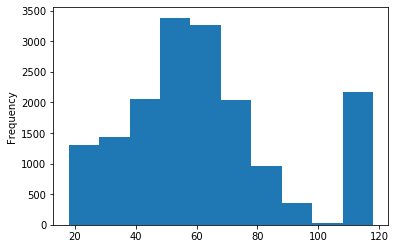

In [20]:
profile['age'].plot(kind='hist');

There is an outlier on the age variable 

In [21]:
#extract membership age, day, weekday, month and year from become_member_on
profile['membership_start_date'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['mem_start_day'] = np.uint8(profile['membership_start_date'].dt.day)
profile['mem_start_weekday'] = profile['membership_start_date'].dt.dayofweek
profile['mem_start_month'] = np.uint8(profile['membership_start_date'].dt.month)
profile['mem_start_year'] = profile['membership_start_date'].dt.year

In [22]:
profile['membership_age'] = round((pd.datetime.now() - profile['membership_start_date']).dt.days/365*12, 1)
profile.head()

,gender,age,id,became_member_on,income,membership_start_date,mem_start_day,mem_start_weekday,mem_start_month,mem_start_year,membership_age
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,12,6,2,2017,45.2
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,15,5,7,2017,40.2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,12,3,7,2018,28.3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,9,1,5,2017,42.4
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,4,4,8,2017,39.6


In [23]:
profile = profile.drop(['became_member_on','membership_start_date'], axis=1)

In [24]:
profile.rename(columns={'id':'cust_id'}, inplace=True)
profile.head()

,gender,age,cust_id,income,mem_start_day,mem_start_weekday,mem_start_month,mem_start_year,membership_age
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,12,6,2,2017,45.2
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,15,5,7,2017,40.2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,12,3,7,2018,28.3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,9,1,5,2017,42.4
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,4,4,8,2017,39.6


In [25]:
print('Total number of user profiles:',profile['cust_id'].nunique())

Total number of user profiles: 17000


In [26]:
print('Total number of user profiles with transaction',transcript['person'].nunique())

Total number of user profiles with transaction 17000


In [27]:
male = profile[profile['gender']=='M']
female = profile[profile['gender']=='F']
other = profile[profile['gender']=='O']

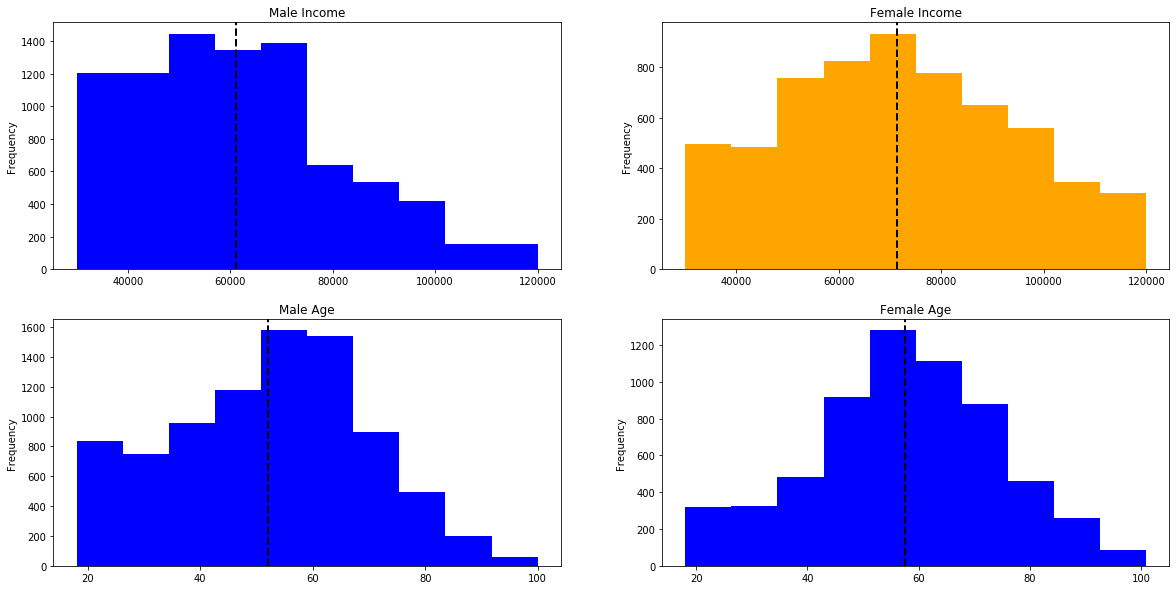

In [28]:
plt.figure(figsize=(20, 10));
plt.subplot(2, 2, 1)
male['income'].plot(kind='hist', title = 'Male Income', color='blue');
plt.axvline(male.income.mean(), color='k', linestyle='dashed', linewidth=2);

plt.subplot(2, 2, 2)
female['income'].plot(kind='hist', title = 'Female Income', color = 'orange');
plt.axvline(female.income.mean(), color='k', linestyle='dashed', linewidth=2);

plt.subplot(2, 2, 3)
male['age'].plot(kind='hist', title = 'Male Age', color = 'blue');
plt.axvline(male.age.mean(), color='k', linestyle='dashed', linewidth=2);

plt.subplot(2, 2, 4)
female['age'].plot(kind='hist', title = 'Female Age', color = 'blue');
plt.axvline(female.age.mean(), color='k', linestyle='dashed', linewidth=2);

It can be the seen that the minimum and maximum wage for male and female are the same 
but the male income starts flattening out towards high income.
Also, the average for the female income is greater than than the male income as seen from the dashed line

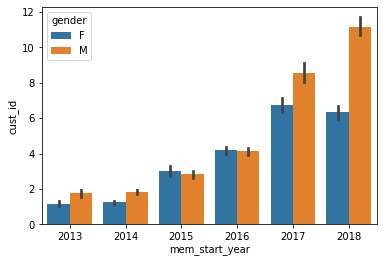

In [29]:
gender_count = profile[profile['gender']!='O'].groupby(['gender','mem_start_year','mem_start_month','mem_start_day','mem_start_weekday']).agg({'cust_id':'count'}).reset_index()
sns.barplot(x='mem_start_year', y='cust_id', hue = 'gender', data = gender_count)

membership has increased over the years. Also, male membership is greater than the female membership every year

# Transcript

In [30]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [31]:
np.sum(transcript.isnull())

person    0
event     0
value     0
time      0
dtype: int64

In [32]:
transcript.event.value_counts(dropna=False)

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [33]:
#filtering since it runs for couple of mins
#extracting data from the value field
#transcript_value = transcript['value'].apply(pd.Series)

In [34]:
transcript_value = pd.read_csv('transacript_value.csv')

In [35]:
transcript_value.drop(['Unnamed: 0'], axis=1,inplace=True)
transcript_value.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [36]:
#cleaning up the offer id
transcript_value['offer_id_new']=np.where(transcript_value['offer id'].isnull() & transcript_value['offer_id'].notnull(),\
                                          transcript_value['offer_id'],
                                          transcript_value['offer id']
                                         )

In [37]:
#transcript_value.drop(['Unnamed: 0'], axis=1, inplace=True)
transcript_value.head(2)

,offer id,amount,offer_id,reward,offer_id_new
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [38]:
#merging with the original transcript df
full_transcript = pd.concat([transcript, transcript_value], axis=1)

In [39]:
full_transcript.head(2)

,person,event,value,time,offer id,amount,offer_id,reward,offer_id_new
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [40]:
#convert time in hours to time in days 
full_transcript['time_days'] = full_transcript['time']/24 
#drop the unncessary columns
full_transcript.drop(['value','offer_id','offer id','time'], axis=1, inplace=True)
#rename the columns
full_transcript.rename(columns = {'person':'cust_id','offer_id_new':'offer_id','reward':'reward_complete'}, inplace=True)

In [41]:
full_transcript=full_transcript.sort_values(['cust_id','time_days'])

In [42]:
np.sum(full_transcript.isnull())

cust_id                 0
event                   0
amount             167581
reward_complete    272955
offer_id           138953
time_days               0
dtype: int64

In [43]:
full_transcript[full_transcript['offer_id'].isnull()].event.value_counts()

transaction    138953
Name: event, dtype: int64

In [44]:
full_transcript[full_transcript['amount'].notnull()].event.value_counts()

transaction    138953
Name: event, dtype: int64

In [45]:
full_transcript[full_transcript['reward_complete'].notnull()].event.value_counts()

offer completed    33579
Name: event, dtype: int64

it was identified that the event 'transaction' will not have any offer id associated with it, reward_complete is available for only 'offer completed' event and 'amount' is available only for the 'transaction' event

In [46]:
#bogo type
full_transcript[full_transcript['cust_id']=='78afa995795e4d85b5d9ceeca43f5fef'].head(4)

,cust_id,event,amount,reward_complete,offer_id,time_days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.25
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,19.89,NaN,NaN,5.50
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.50


In [47]:
#informational
full_transcript[full_transcript['cust_id']=='0009655768c64bdeb2e877511632db8f'].head(3)

,cust_id,event,amount,reward_complete,offer_id,time_days
55972,0009655768c64bdeb2e877511632db8f,offer received,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,7.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,8.0
89291,0009655768c64bdeb2e877511632db8f,transaction,22.16,NaN,NaN,9.5


We already know that there are four events : offer received, offer viewed, transaction and offer completed
and three offer types: informational, bogo and discount

The general flow of the event for:
* informational : received > viewed > transaction (there if no completed event since there is no reward associated with this type)
* bogo and discount : received > viewed > transaction > completed 

But there is no offer id associated with the transaction event. 

Our first data pre-processing is identifying the offer id associated with the transaction event

In [48]:
#for viewed, received, transaction records, forward fill the offers
miss_offer = full_transcript[(full_transcript['event']=='transaction')|(full_transcript['event']=='offer viewed')|(full_transcript['event']=='offer received')][['time_days','offer_id','cust_id','event']].ffill()

#merged with the main df and cleanup the offer id
full_transcript = full_transcript.merge(miss_offer, how = 'left', on=['cust_id','time_days','event'])
full_transcript['new_offer_id']=np.where(full_transcript['offer_id_x'].isnull(),full_transcript['offer_id_y'],full_transcript['offer_id_x'])

#free up the memory
del miss_offer

#drop unnecessary columns and rename the offer id
full_transcript.drop(['offer_id_x','offer_id_y'], axis=1, inplace=True)
full_transcript = full_transcript.rename(columns={'new_offer_id':'offer_id'})

In [49]:
full_transcript.head(3)

,cust_id,event,amount,reward_complete,time_days,offer_id
0,0009655768c64bdeb2e877511632db8f,offer received,NaN,NaN,7.0,5a8bc65990b245e5a138643cd4eb9837
1,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,NaN,8.0,5a8bc65990b245e5a138643cd4eb9837
2,0009655768c64bdeb2e877511632db8f,transaction,22.16,NaN,9.5,5a8bc65990b245e5a138643cd4eb9837


In [50]:
#merge with the portfolio df
transcript_portfolio = full_transcript.merge(portfolio, how='left', on='offer_id')
transcript_portfolio.shape

(306534, 14)

Second step is to identify the successful offer (one that caused the customer to make the transaction)

We know the following:
1. effective offer is when the "transaction" event happens.
2. The customer should have viewed the offer

In [51]:
#find the previous offer id and previous event for the customer
transcript_portfolio['previous_offer_id'] = transcript_portfolio.groupby(['cust_id'])['offer_id'].shift()
transcript_portfolio['previous_event'] = transcript_portfolio.groupby(['cust_id'])['event'].shift()

In [52]:
#identify the transactions with the effect of offers 
#where the value will be 1 if the previous event will be viewed for the transaction event
#and the offer id for transaction and offer viewed should be same
transcript_portfolio['offer_effect']= 0
transcript_portfolio.loc[((transcript_portfolio['previous_offer_id']==transcript_portfolio['offer_id'])\
                          &(transcript_portfolio['event']=='transaction')\
                          &(transcript_portfolio['previous_event']=='offer viewed')),'offer_effect']=1

In [53]:
#For the offer to be effective it should have happened within the duration
transcript_portfolio['days_diff'] = transcript_portfolio.groupby(['cust_id','offer_id'])['time_days'].diff()
transcript_portfolio['offer_validity'] = 0
transcript_portfolio.loc[transcript_portfolio['days_diff']<=transcript_portfolio['duration'],'offer_validity']=1

In [54]:
#identify successful offer on the basis of effect and validatity
transcript_portfolio['offer_success']=np.where((transcript_portfolio['offer_effect']==1)\
                                               &(transcript_portfolio['offer_validity']==1),1,0)

In [55]:
#remove the unnecessary columns
transcript_portfolio.drop(['previous_event','previous_offer_id','offer_effect','offer_validity'], axis=1, inplace=True)

In [56]:
#merge with the profile df
all_data = transcript_portfolio.merge(profile, on = 'cust_id', how='left')
all_data.shape

(306534, 24)

In [57]:
all_data.head()

,cust_id,event,amount,reward_complete,time_days,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,days_diff,offer_success,gender,age,income,mem_start_day,mem_start_weekday,mem_start_month,mem_start_year,membership_age
0,0009655768c64bdeb2e877511632db8f,offer received,NaN,NaN,7.0,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,0,1,1,1,NaN,0,M,33,72000.0,21,4,4,2017,43.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,NaN,8.0,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,0,1,1,1,1.0,0,M,33,72000.0,21,4,4,2017,43.0
2,0009655768c64bdeb2e877511632db8f,transaction,22.16,NaN,9.5,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,0,1,1,1,1.5,1,M,33,72000.0,21,4,4,2017,43.0
3,0009655768c64bdeb2e877511632db8f,offer received,NaN,NaN,14.0,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,1,0,NaN,0,M,33,72000.0,21,4,4,2017,43.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,NaN,15.5,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,1,0,1.5,0,M,33,72000.0,21,4,4,2017,43.0


In [58]:
#all_data['offer_success']=all_data['offer_success'].astype('object')
all_data['offer_success'].value_counts(dropna=False, normalize = True)

0    0.867884
1    0.132116
Name: offer_success, dtype: float64

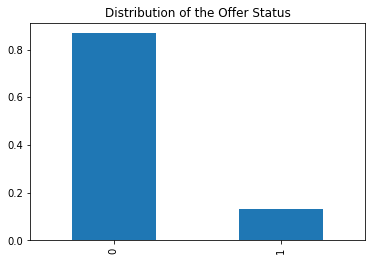

In [59]:
all_data['offer_success'].value_counts(dropna=False, normalize = True).plot(kind='bar', title = 'Distribution of the Offer Status');

This is a highly imbalanced dataset and we will need to run the data processing to adjust that

In [60]:
offer_stats = all_data.groupby(['offer_id','offer_type']).agg({'cust_id':'nunique','offer_success':'sum'})
offer_stats['percent_success'] = np.round(offer_stats['offer_success']/offer_stats['cust_id']*100,2)
offer_stats.sort_values(by='percent_success', ascending=False)

,,cust_id,offer_success,percent_success
offer_id,offer_type,,,
fafdcd668e3743c1bb461111dcafc2a4,discount,6503,5689,87.48
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,6527,5559,85.17
f19421c1d4aa40978ebb69ca19b0e20d,bogo,6442,5188,80.53
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,6508,5240,80.52
ae264e3637204a6fb9bb56bc8210ddfd,bogo,6533,5029,76.98
5a8bc65990b245e5a138643cd4eb9837,informational,6492,3982,61.34
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,6518,2864,43.94
2906b810c7d4411798c6938adc9daaa5,discount,6456,2798,43.34
3f207df678b143eea3cee63160fa8bed,informational,6509,2421,37.19


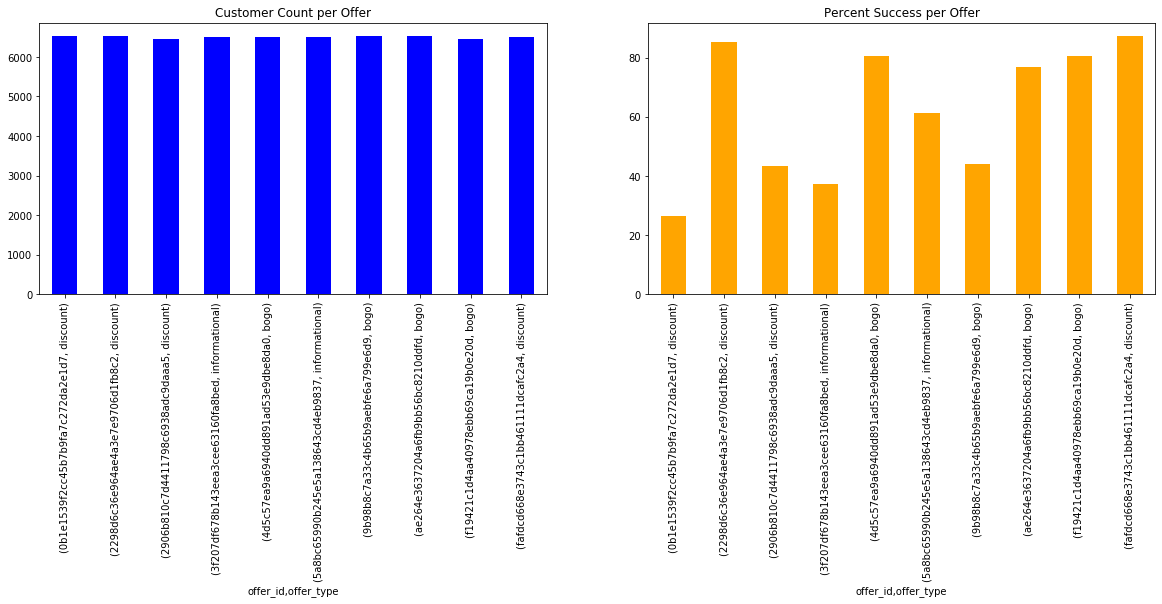

In [61]:
plt.figure(figsize=(20, 5));
plt.subplot(1, 2, 1)
offer_stats['cust_id'].plot(kind='bar', title = 'Customer Count per Offer', color='blue');
#plt.axvline(male.income.mean(), color='k', linestyle='dashed', linewidth=2);

plt.subplot(1, 2, 2)
offer_stats['percent_success'].plot(kind='bar', title = 'Percent Success per Offer', color = 'orange');
#plt.axvline(female.income.mean(), color='k', linestyle='dashed', linewidth=2);

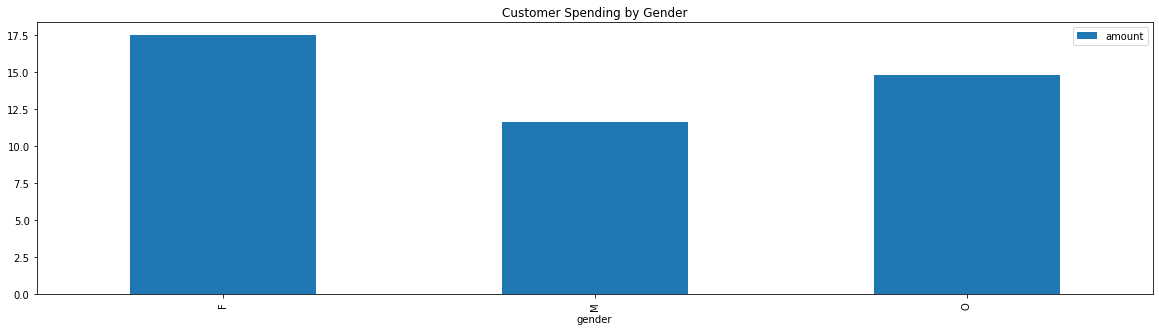

In [62]:
all_data.groupby('gender').agg({'amount':'mean'}).plot(kind='bar', title = 'Customer Spending by Gender', figsize=(20,5));

In [63]:
# checking missing data
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data[missing_train_data['Percent']>0]

,Total,Percent
reward_complete,272955,89.045587
amount,167581,54.669629
days_diff,65028,21.213960
income,33772,11.017375
gender,33772,11.017375


# Handling Unbalanced Dataset

In [97]:
#get the count of event for each offer id per customer
event_counts = all_data.groupby(['cust_id','offer_id','event'])['event'].count().unstack('event').reset_index()
#get only the final offer status
df_success = all_data.groupby(['cust_id','offer_id']).agg({'offer_success':'max','amount':'sum'}).reset_index()
#get the remaining cols
df_rem = all_data[['cust_id','offer_id','offer_type','gender','age','income','mem_start_day','mem_start_weekday',
                   'mem_start_month','membership_age', 'reward','difficulty','duration',
                   'web','email','mobile','social', #'time_days', 'days_diff'#,'amount'
                   #,'amount','reward_complete'
                  ]].drop_duplicates()

#amount,'reward_complete', 'time_days'
df_rcvd = all_data[all_data['event']=='offer received'][['cust_id','offer_id','time_days']]

#merge the dfs
reduced_tp = event_counts[['cust_id','offer_id','offer received','offer viewed','transaction','offer completed']]\
             .merge(df_success, on = ['cust_id','offer_id'], how='left' )#.fillna(0)
reduced_tp = reduced_tp.merge(df_rem, on = ['cust_id','offer_id'], how='left' )
reduced_tp = reduced_tp.merge(df_rcvd, on = ['cust_id','offer_id'], how='left' )

#reduced_tp.fillna(0, inplace=True)
reduced_tp.shape

(78017, 24)

In [98]:
reduced_tp['offer_success'].value_counts(dropna=False, normalize = True)

1    0.576695
0    0.423305
Name: offer_success, dtype: float64

In [99]:
# checking missing data
total = reduced_tp.isnull().sum().sort_values(ascending = False)
percent = (reduced_tp.isnull().sum()/reduced_tp.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data[missing_train_data['Percent']>0]

,Total,Percent
offer completed,42020,53.860056
offer viewed,17732,22.728380
transaction,15390,19.726470
income,9979,12.790802
gender,9979,12.790802
offer received,1740,2.230283
time_days,1740,2.230283


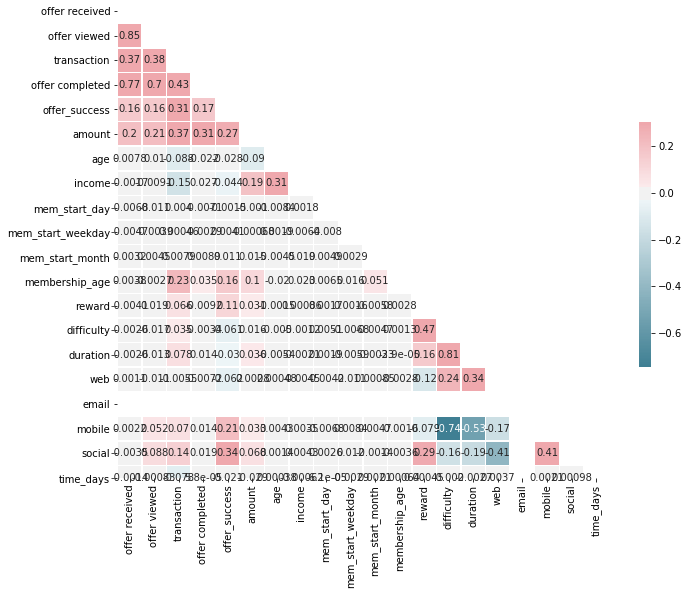

In [100]:
#Correlation Plot
# Creating correlation matrix 

corr = reduced_tp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [101]:
feats = reduced_tp.drop(['offer_success','offer viewed', 'offer completed','transaction','cust_id','offer_id','amount'], axis=1)
feats.columns

Index(['offer received', 'offer_type', 'gender', 'age', 'income',
       'mem_start_day', 'mem_start_weekday', 'mem_start_month',
       'membership_age', 'reward', 'difficulty', 'duration', 'web', 'email',
       'mobile', 'social', 'time_days'],
      dtype='object')

In [102]:
def plot_distribution(df, feat):
    '''
    input
    df: dataframe
    feature: features to plot the univariate distribution
    '''
    fig, ax = plt.subplots(figsize=(17,5))
    sns.countplot(df[feat])
    ax.xaxis.set_label_text(feat,fontdict= {'size':14})
    ax.yaxis.set_label_text("Count",fontdict= {'size':14})
    plt.show()
    print(f"Total number of unique values for feature {feat} is {df[feat].nunique()}")
    print(100 * df[feat].value_counts(normalize=True, dropna=False))

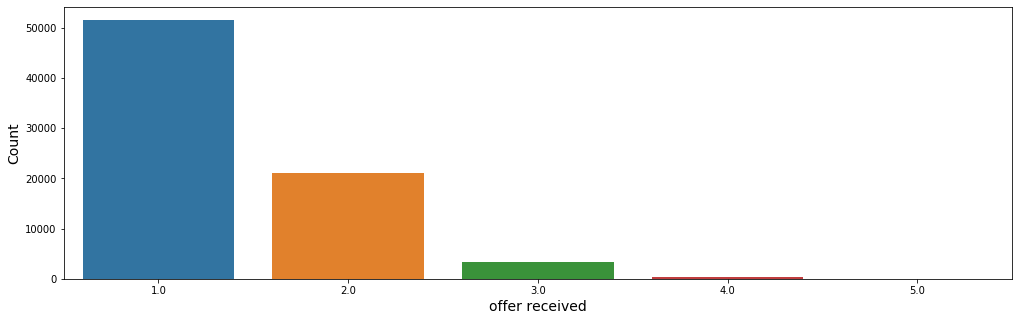

Total number of unique values for feature offer received is 5
1.0    66.100978
2.0    26.976172
3.0     4.322135
NaN     2.230283
4.0     0.338388
5.0     0.032044
Name: offer received, dtype: float64


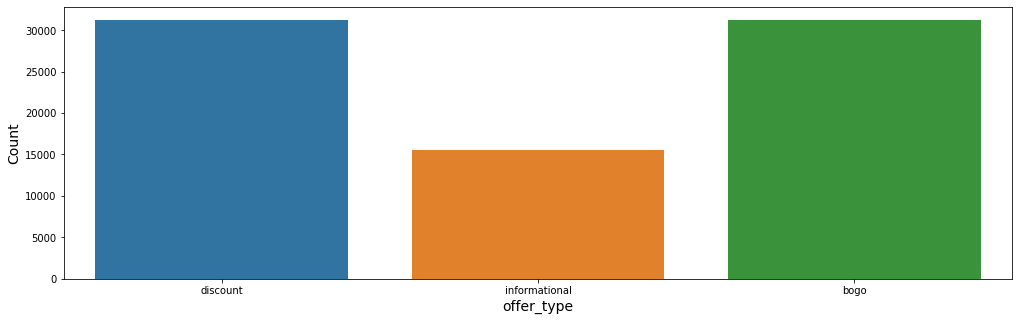

Total number of unique values for feature offer_type is 3
discount         40.059218
bogo             39.964367
informational    19.976415
Name: offer_type, dtype: float64


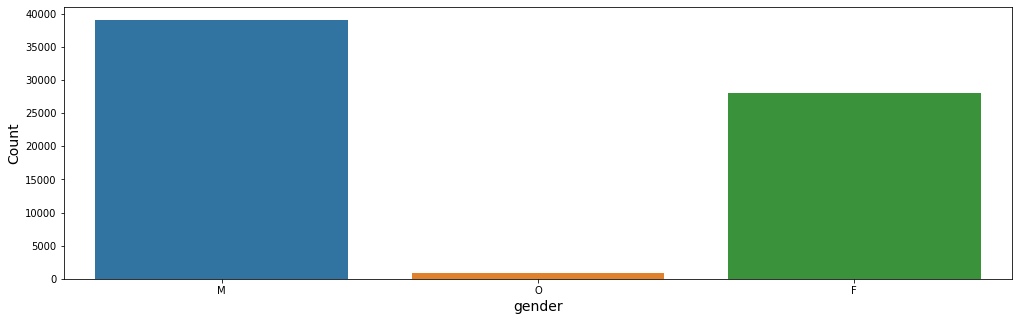

Total number of unique values for feature gender is 3
M      50.049348
F      35.957548
NaN    12.790802
O       1.202302
Name: gender, dtype: float64


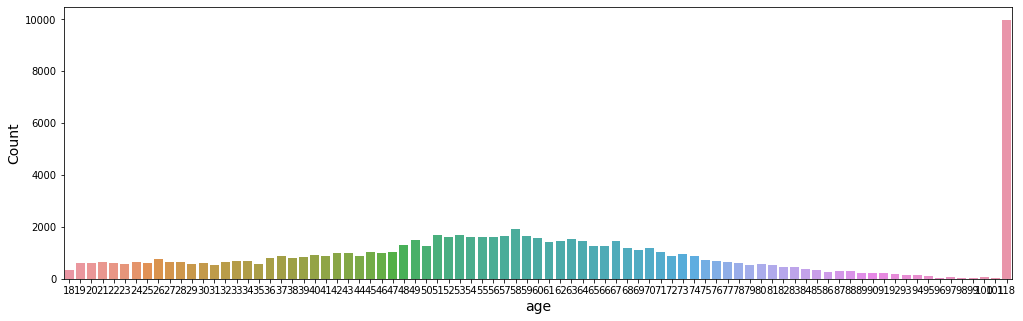

Total number of unique values for feature age is 85
118    12.790802
58      2.450748
53      2.161067
51      2.153377
59      2.095697
         ...    
100     0.066652
96      0.048707
99      0.033326
101     0.029481
98      0.025635
Name: age, Length: 85, dtype: float64


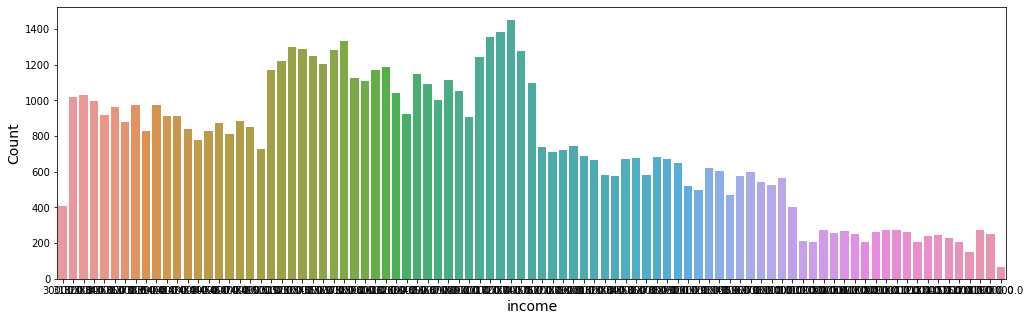

Total number of unique values for feature income is 91
NaN         12.790802
73000.0      1.859851
72000.0      1.772691
71000.0      1.740646
57000.0      1.711166
              ...    
112000.0     0.265327
107000.0     0.264045
102000.0     0.261481
117000.0     0.192266
120000.0     0.082033
Name: income, Length: 92, dtype: float64


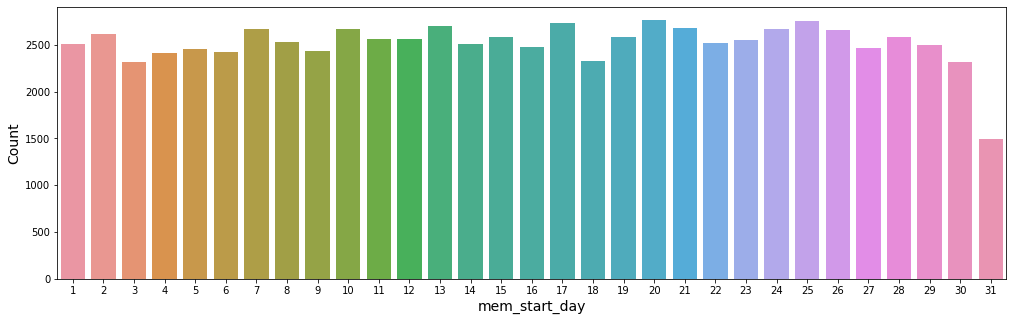

Total number of unique values for feature mem_start_day is 31
20    3.547945
25    3.537691
17    3.497956
13    3.463348
21    3.428740
7     3.427458
10    3.424895
24    3.417204
26    3.405668
2     3.351834
15    3.314662
19    3.308253
28    3.306972
12    3.280054
11    3.280054
23    3.267237
8     3.244165
22    3.223656
14    3.221093
1     3.209557
29    3.205712
16    3.172386
27    3.159568
5     3.153159
9     3.117269
6     3.105733
4     3.086507
18    2.985247
30    2.971147
3     2.968584
31    1.916249
Name: mem_start_day, dtype: float64


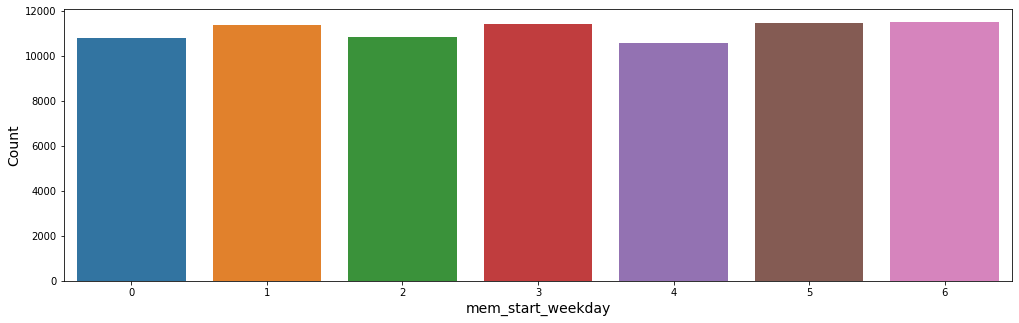

Total number of unique values for feature mem_start_weekday is 7
6    14.766013
5    14.712178
3    14.648090
1    14.566056
2    13.917480
0    13.835446
4    13.554738
Name: mem_start_weekday, dtype: float64


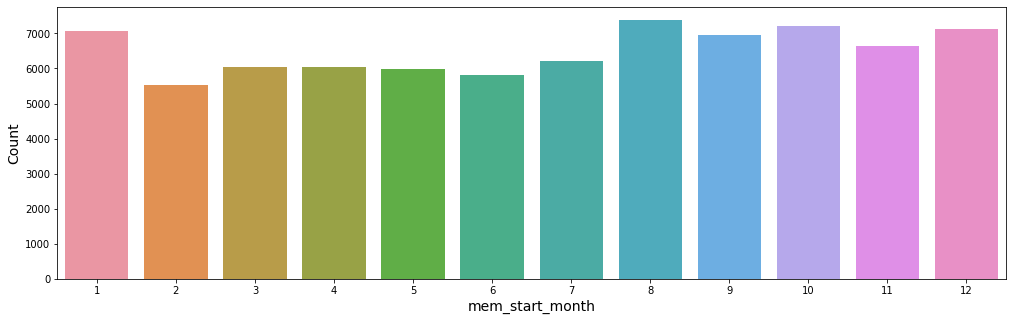

Total number of unique values for feature mem_start_month is 12
8     9.472294
10    9.233885
12    9.133907
1     9.054437
9     8.912160
11    8.530192
7     7.971340
3     7.736775
4     7.732930
5     7.671405
6     7.453504
2     7.097171
Name: mem_start_month, dtype: float64


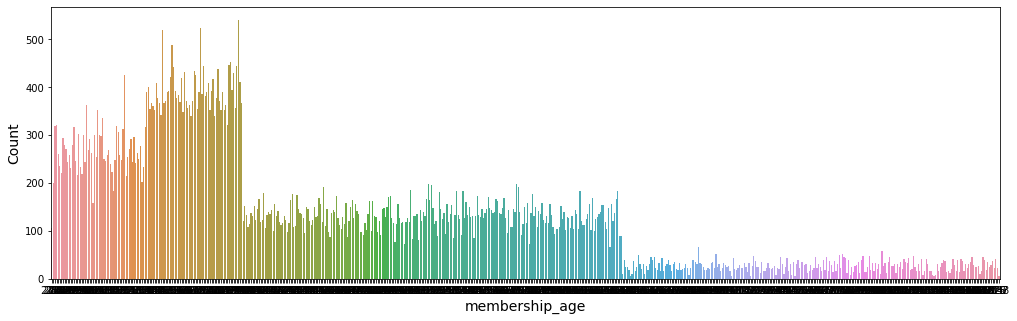

Total number of unique values for feature membership_age is 600
39.6    0.693439
37.2    0.670367
34.8    0.665240
35.4    0.625505
39.1    0.579361
          ...   
72.1    0.007691
83.7    0.007691
74.9    0.007691
64.4    0.007691
70.9    0.006409
Name: membership_age, Length: 600, dtype: float64


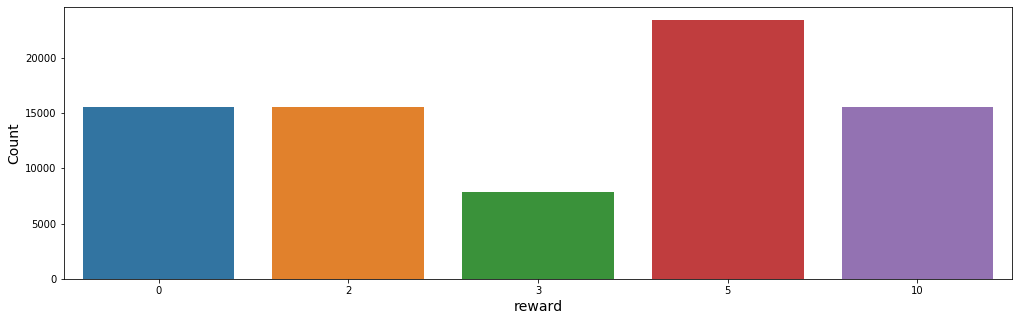

Total number of unique values for feature reward is 5
5     30.025507
10    19.980261
0     19.976415
2     19.958471
3     10.059346
Name: reward, dtype: float64


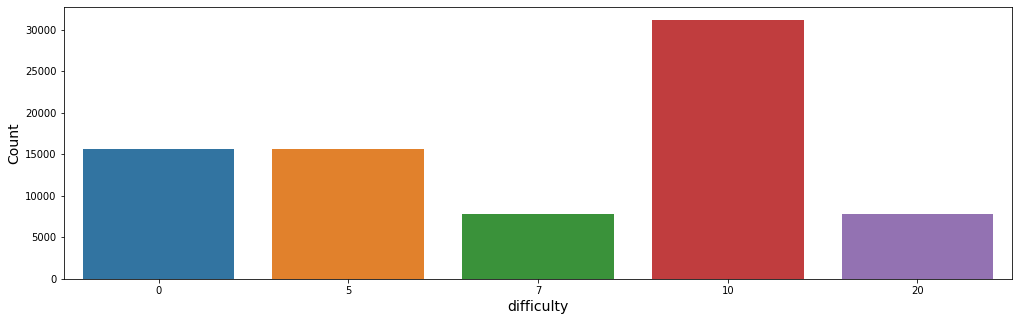

Total number of unique values for feature difficulty is 5
10    39.938731
5     19.984106
0     19.976415
7     10.059346
20    10.041401
Name: difficulty, dtype: float64


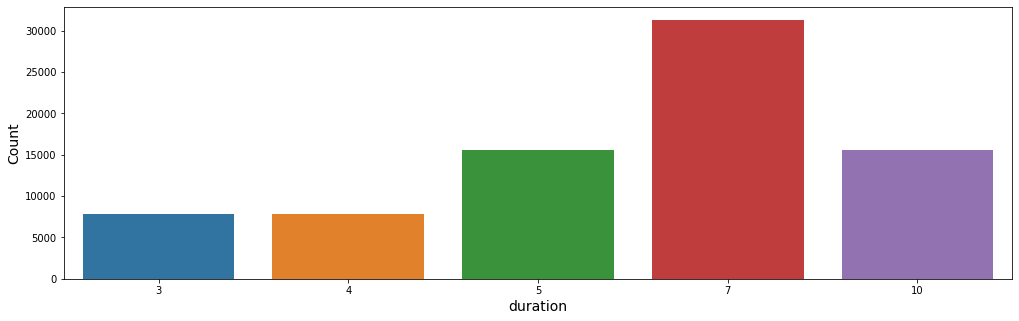

Total number of unique values for feature duration is 5
7     40.129715
10    19.998206
5     19.895664
4      9.991412
3      9.985003
Name: duration, dtype: float64


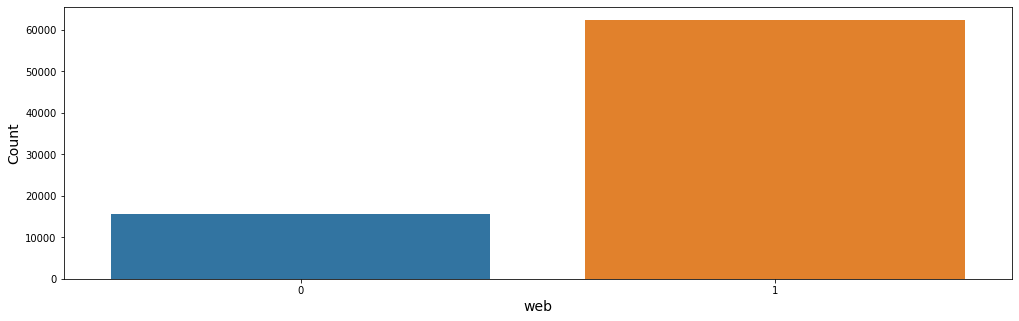

Total number of unique values for feature web is 2
1    79.995386
0    20.004614
Name: web, dtype: float64


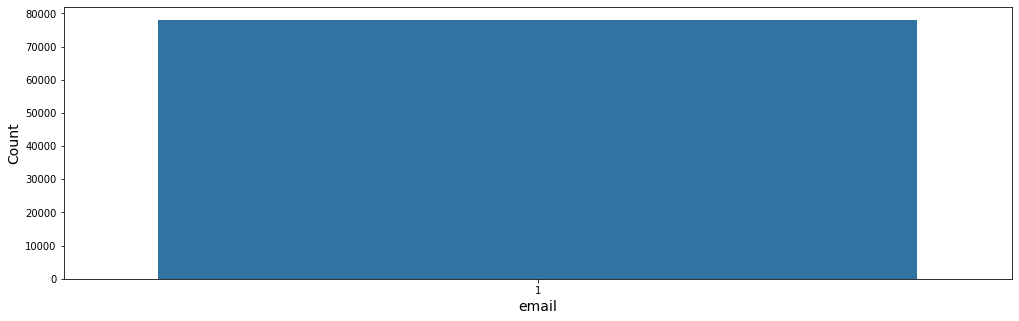

Total number of unique values for feature email is 1
1    100.0
Name: email, dtype: float64


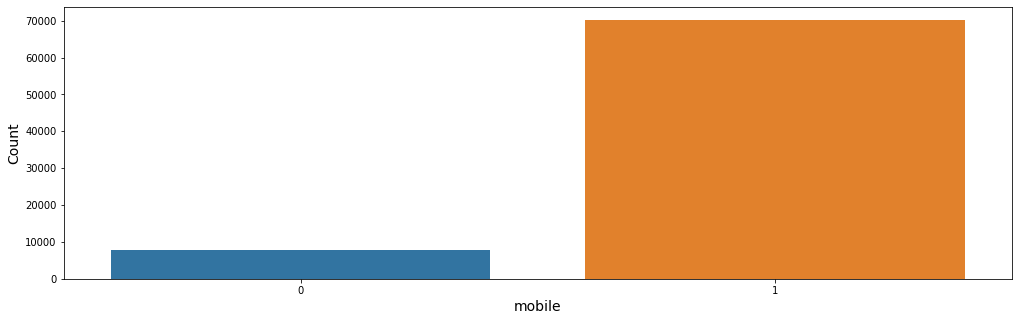

Total number of unique values for feature mobile is 2
1    89.958599
0    10.041401
Name: mobile, dtype: float64


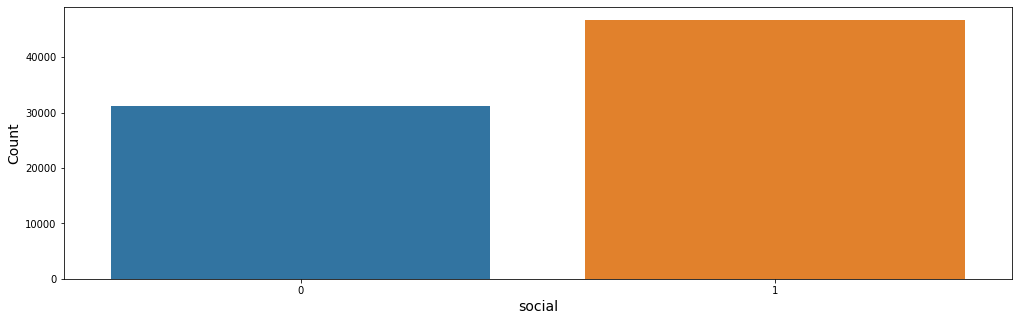

Total number of unique values for feature social is 2
1    59.916428
0    40.083572
Name: social, dtype: float64


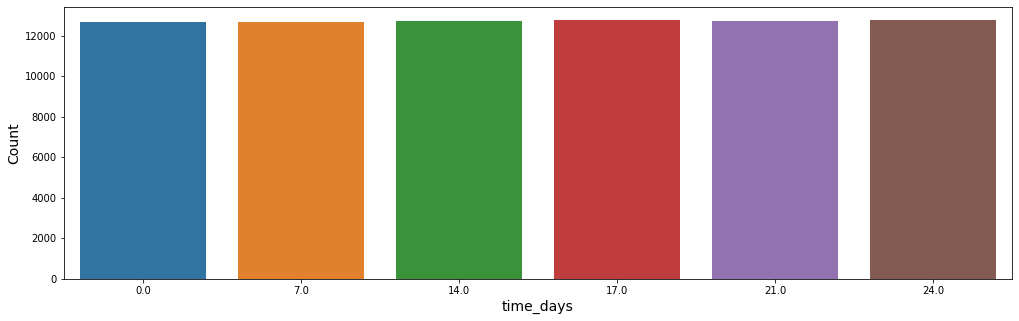

Total number of unique values for feature time_days is 6
17.0    16.378482
24.0    16.361819
14.0    16.292603
21.0    16.283630
7.0     16.238768
0.0     16.214415
NaN      2.230283
Name: time_days, dtype: float64


In [70]:
#univariate analysis
for i in feats:
    plot_distribution(reduced_tp, i)

In [103]:
#dropping columns based on correlation plot and univariate analysis

#we know that offer success was based on the event - viewed and transaction
#also as can be seen from above, email has only one distinct values
#offer completed is highly correlated with offer received

reduced_tp.drop(['offer viewed', 'offer completed','transaction','email'], axis=1, inplace=True)
reduced_tp.shape

(78017, 20)

In [104]:
#there are records with no offers received, 
#these are customers who have made the transactions irrespective of the offer, so lets remove them
reduced_tp[reduced_tp['offer received'].isnull()]['offer_success'].value_counts()

0    1740
Name: offer_success, dtype: int64

In [105]:
#removing the above records
reduced_tp = reduced_tp[reduced_tp['offer received'].notnull()]
reduced_tp.shape

(76277, 20)

In [106]:
#13% of the customers have no income data, removing
reduced_tp = reduced_tp[reduced_tp['income'].notnull()]
reduced_tp.shape

(66501, 20)

In [107]:
reduced_tp.head(2)

,cust_id,offer_id,offer received,offer_success,amount,offer_type,gender,age,income,mem_start_day,mem_start_weekday,mem_start_month,membership_age,reward,difficulty,duration,web,mobile,social,time_days
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,0,69.2,discount,M,33,72000.0,21,4,4,43.0,2,10,7,1,1,0,24.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,0,0.0,informational,M,33,72000.0,21,4,4,43.0,0,0,4,1,1,0,14.0


# Feature Engineering

In [108]:
def frequency_encoding(df, col_name):
    '''
    input:
    - df, col_name: dataframe and the columns passed for encodin
    output:
    - df: dataframe with frequency encoded columns
    '''
    new_name = "{}_counts".format(col_name)
    new_col_name = "{}_freq".format(col_name)
    grouped = df.groupby(col_name).size().reset_index(name=new_name)
    df = df.merge(grouped, how = "left", on = col_name)
    df[new_col_name] = df[new_name]/df[new_name].count()
    del df[new_name]
    return df

In [109]:
%%time
categorical_features = ["offer_id","cust_id"]
#applying frequency encoding on offer id and cust id
for cat in categorical_features:
    print("Frequency encoding for {}".format(cat))
    reduced_tp = frequency_encoding(reduced_tp, cat)
        
    

Frequency encoding for offer_id
Frequency encoding for cust_id
Wall time: 196 ms


In [110]:
#https://www.kaggle.com/tnarik/likelihood-encoding-of-categorical-features
from sklearn.model_selection import KFold
def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    
     input:
    - data: dataframe 
    - feature: columns passed for target encoding
    - target
    output:
    - df: dataframe with frequency encoded columns
    
    '''
    n_folds = 5
    n_inner_folds = 3
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded

In [111]:
%%time
impact_coding_map = {}
for f in categorical_features:
        print("Impact coding for {}".format(f))
        reduced_tp["impact_encoded_{}".format(f)] = impact_coding(reduced_tp, f, target="offer_success")
        #impact_coding_map[f] = (impact_coding_mapping, default_coding)
        #mapping, default_mean = impact_coding_map[f]


Impact coding for offer_id
Impact coding for cust_id
Wall time: 1min 49s


In [113]:
dups = reduced_tp.copy()

In [114]:
%%time
#Aggregate functions
aggs = {
    'income': ['sum', 'mean'],
    'age': ['sum', 'mean'],
    'amount': ['mean'],
}

agg_train = reduced_tp.groupby(['cust_id','offer_id']).agg(aggs)
new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_train.columns = new_columns
agg_train = agg_train.reset_index()

reduced_tp = reduced_tp.merge(agg_train, on =['cust_id','offer_id'], how='left')
reduced_tp.shape

Wall time: 224 ms


(66501, 29)

In [115]:
%%time
#Aggregate functions
aggs = {
    'income': ['sum', 'mean'],
    'age': ['sum', 'mean'],
    'amount': ['mean'],
}

agg_train = reduced_tp.groupby(['offer_id']).agg(aggs)
new_columns = [k + '_offer_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_train.columns = new_columns
agg_train = agg_train.reset_index()

reduced_tp = reduced_tp.merge(agg_train, on =['offer_id'], how='left')
reduced_tp.shape

Wall time: 136 ms


(66501, 34)

In [116]:
reduced_tp.head()

,cust_id,offer_id,offer received,offer_success,amount,offer_type,gender,age,income,mem_start_day,mem_start_weekday,mem_start_month,membership_age,reward,difficulty,duration,web,mobile,social,time_days,offer_id_freq,cust_id_freq,impact_encoded_offer_id,impact_encoded_cust_id,income_sum,income_mean,age_sum,age_mean,amount_mean,income_offer_sum,income_offer_mean,age_offer_sum,age_offer_mean,amount_offer_mean
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,0,69.20,discount,M,33,72000.0,21,4,4,43.0,2,10,7,1,1,0,24.0,0.099713,0.000075,0.425453,0.355556,72000.0,72000.0,33,33,69.20,434118000.0,65467.953552,359270,54.180365,30.892470
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,0,0.00,informational,M,33,72000.0,21,4,4,43.0,0,0,4,1,1,0,14.0,0.100104,0.000075,0.367297,0.355556,72000.0,72000.0,33,33,0.00,433914000.0,65181.613339,363213,54.561064,26.298998
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,1,22.16,informational,M,33,72000.0,21,4,4,43.0,0,0,3,0,1,1,7.0,0.099893,0.000075,0.607415,0.416667,72000.0,72000.0,33,33,22.16,435530000.0,65562.245973,362433,54.558633,28.710461
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,0,8.57,bogo,M,33,72000.0,21,4,4,43.0,5,5,5,1,1,1,17.0,0.098886,0.000075,0.751004,0.388889,72000.0,72000.0,33,33,8.57,430685000.0,65493.461071,358227,54.474909,37.926346
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1,27.67,discount,M,33,72000.0,21,4,4,43.0,2,10,10,1,1,1,21.0,0.100029,0.000075,0.810664,0.416667,72000.0,72000.0,33,33,27.67,435053000.0,65401.834035,361934,54.409802,46.732195


In [117]:
from sklearn import preprocessing
cat_cols = ['cust_id','offer_id','offer_type','gender']
le = preprocessing.LabelEncoder()

def label_encoder(df):
    '''
    input:
    - df : dataframe and the columns passed for encodin
    '''
    for i in cat_cols:
        print('Converting {}'.format(i))
        df[i] = le.fit_transform(df[i])

In [118]:
#apply label encoding
label_encoder(reduced_tp)

Converting cust_id
Converting offer_id
Converting offer_type
Converting gender


In [119]:
reduced_tp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 34 columns):
cust_id                    66501 non-null int32
offer_id                   66501 non-null int32
offer received             66501 non-null float64
offer_success              66501 non-null int32
amount                     66501 non-null float64
offer_type                 66501 non-null int32
gender                     66501 non-null int32
age                        66501 non-null int64
income                     66501 non-null float64
mem_start_day              66501 non-null uint8
mem_start_weekday          66501 non-null int64
mem_start_month            66501 non-null uint8
membership_age             66501 non-null float64
reward                     66501 non-null int64
difficulty                 66501 non-null int64
duration                   66501 non-null int64
web                        66501 non-null int64
mobile                     66501 non-null int64
social             

In [120]:
np.sum(reduced_tp.isnull())

cust_id                    0
offer_id                   0
offer received             0
offer_success              0
amount                     0
offer_type                 0
gender                     0
age                        0
income                     0
mem_start_day              0
mem_start_weekday          0
mem_start_month            0
membership_age             0
reward                     0
difficulty                 0
duration                   0
web                        0
mobile                     0
social                     0
time_days                  0
offer_id_freq              0
cust_id_freq               0
impact_encoded_offer_id    0
impact_encoded_cust_id     0
income_sum                 0
income_mean                0
age_sum                    0
age_mean                   0
amount_mean                0
income_offer_sum           0
income_offer_mean          0
age_offer_sum              0
age_offer_mean             0
amount_offer_mean          0
dtype: int64

In [121]:
#splitting the dataframe into features and target
features = reduced_tp.drop(['offer_success','offer_id','cust_id'], axis=1)
target = reduced_tp['offer_success']

In [122]:
#Setup for 5 K-Fold validation
n_fold = 5
folds = KFold(n_splits=n_fold, random_state=42)

In [123]:
#split the features and target intp train and test
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

In [124]:
def train_model(X, X_test, y, params=None, model_type='lgb', plot_feature_importance=False):
    '''
   input
   -X : train dataset
   -X_test: test dataset
   -y : train target
   -params: paramaters for train the model
   -model_type: classifier name
   -plot_feature_importaince: indicator to plot the feature importance
   
   output
   -prediction - predicted target for test 
   '''
    #oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    mse = []
    scores = []
    f1 = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y.values[train_index], y.values[valid_index]
        
        if model_type=='rf':
            model = RandomForestClassifier(**params)
            model.fit(X_train, y_train)
            pred_valid = model.predict(X_valid)
            pred_test = model.predict(X_test)
            
                
        if model_type=='lgb':
            model = lgb.LGBMClassifier(**params)#n_estimators = 20000
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='error',  
                      verbose=1000, early_stopping_rounds=200)
            
            pred_valid = model.predict(X_valid)
            pred_test = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type=='xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=200, 
                      evals=watchlist, early_stopping_rounds=200, verbose_eval=100,params=params)
            pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit).round()
            pred_test = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)
            
            
        if model_type == 'ada':
            model = AdaBoostClassifier(**params)
            model.fit(X_train, y_train)

            pred_valid = model.predict(X_valid)
            pred_test = model.predict(X_test)
            
        if model_type == 'tree':
            model = DecisionTreeClassifier(**params)
            model.fit(X_train, y_train)
            pred_valid = model.predict(X_valid)
            pred_test = model.predict(X_test)
            
        if model_type == 'gbm':
            model = GradientBoostingClassifier(**params)
            model.fit(X_train, y_train)

            pred_valid = model.predict(X_valid)
            pred_test = model.predict(X_test)    
        
        #oof[valid_index] = pred_valid.reshape(-1,)
        #mse.append(mean_squared_error(y_valid, pred_valid))
        scores.append(accuracy_score(y_valid, pred_valid))
        f1.append(f1_score(y_valid, pred_valid))
        prediction += pred_test 
        
        if model_type == 'rf':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
            
            
    prediction /= n_fold
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    print('CV mean f1 score: {0:.4f}, std: {1:.4f}.'.format(np.mean(f1), np.std(f1)))
    #print(classification_report(y_test, prediction.round(), digits=4))
    
    #return oof, prediction
    if model_type == 'rf':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('Random Forest Features (avg over folds)');
            
        
        
            return prediction, feature_importance
        return prediction
    
    else:
        return prediction

# Random Forest

In [125]:
%%time
params={'random_state':123, 
       'n_estimators':10
       }
prediction_rf = train_model(X, X_test, y, params, model_type='rf', plot_feature_importance=False)

Fold 0 started at Thu Nov 19 12:19:10 2020
Fold 1 started at Thu Nov 19 12:19:11 2020
Fold 2 started at Thu Nov 19 12:19:12 2020
Fold 3 started at Thu Nov 19 12:19:14 2020
Fold 4 started at Thu Nov 19 12:19:15 2020
CV mean score: 0.8960, std: 0.0018.
CV mean f1 score: 0.9128, std: 0.0014.
Wall time: 5.81 s


# LGB

In [91]:
%%time
params={'random_state':123}
prediction_lgb = train_model(X, X_test, y, params, model_type='lgb')

Fold 0 started at Thu Nov 19 12:11:39 2020
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_error: 0.0859962	valid_0's binary_logloss: 0.194526	valid_1's binary_error: 0.103571	valid_1's binary_logloss: 0.233519
Fold 1 started at Thu Nov 19 12:11:40 2020
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_error: 0.0872885	valid_0's binary_logloss: 0.195181	valid_1's binary_error: 0.105545	valid_1's binary_logloss: 0.234663
Fold 2 started at Thu Nov 19 12:11:42 2020
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_error: 0.0881344	valid_0's binary_logloss: 0.197679	valid_1's binary_error: 0.0991541	valid_1's binary_logloss: 0.222447
Fold 3 started at Thu Nov 19 12:11:43 2020
Training until validation scores don't improve for 200 rounds.
Di

# XGB

In [92]:
%%time
params = {'objective': 'binary:logistic',
          'eval_metric': 'error',
          'seed': 11,
          'silent': True}
prediction_xgb = train_model(X, X_test, y, params, model_type='xgb')

Fold 0 started at Thu Nov 19 12:11:46 2020
[0]	train-error:0.109375	valid_data-error:0.111936
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't improved in 200 rounds.
[100]	train-error:0.063534	valid_data-error:0.102914
[199]	train-error:0.031626	valid_data-error:0.105451
Fold 1 started at Thu Nov 19 12:11:55 2020
[0]	train-error:0.108059	valid_data-error:0.116353
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't improved in 200 rounds.
[100]	train-error:0.062735	valid_data-error:0.105639
[199]	train-error:0.030404	valid_data-error:0.104417
Fold 2 started at Thu Nov 19 12:12:03 2020
[0]	train-error:0.111396	valid_data-error:0.106203
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't improved in 200 rounds.
[100]	train-error:0.06539	valid_

# Decision Tree 

In [93]:
%%time
params={'random_state':123 }
prediction_tree = train_model(X, X_test, y, params, model_type='tree')

Fold 0 started at Thu Nov 19 12:12:28 2020
Fold 1 started at Thu Nov 19 12:12:29 2020
Fold 2 started at Thu Nov 19 12:12:30 2020
Fold 3 started at Thu Nov 19 12:12:30 2020
Fold 4 started at Thu Nov 19 12:12:31 2020
CV mean score: 0.8620, std: 0.0028.
CV mean f1 score: 0.8831, std: 0.0030.
Wall time: 3.09 s


# AdaBoost

In [94]:
%%time
params={'random_state':123 }
prediction_ada = train_model(X, X_test, y, params, model_type='ada')

Fold 0 started at Thu Nov 19 12:12:31 2020
Fold 1 started at Thu Nov 19 12:12:36 2020
Fold 2 started at Thu Nov 19 12:12:41 2020
Fold 3 started at Thu Nov 19 12:12:45 2020
Fold 4 started at Thu Nov 19 12:12:50 2020
CV mean score: 0.8865, std: 0.0028.
CV mean f1 score: 0.9060, std: 0.0028.
Wall time: 23.3 s


# GBM

In [95]:
%%time
params={'random_state':123 }
prediction_gbm = train_model(X, X_test, y, params, model_type='gbm')

Fold 0 started at Thu Nov 19 12:12:55 2020
Fold 1 started at Thu Nov 19 12:13:03 2020
Fold 2 started at Thu Nov 19 12:13:11 2020
Fold 3 started at Thu Nov 19 12:13:20 2020
Fold 4 started at Thu Nov 19 12:13:28 2020
CV mean score: 0.8956, std: 0.0030.
CV mean f1 score: 0.9142, std: 0.0026.
Wall time: 42.3 s


# Model Evaluation

In [126]:
#random forest
report = classification_report(y_test, prediction_rf.round(), output_dict=True )
df0=pd.DataFrame(list(report['0'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df0['class']=0
df1=pd.DataFrame(list(report['1'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df1['class']=1
df2 = pd.DataFrame(list(report['macro avg'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df2['class']='macro avg'
df_rf = pd.concat([df0, df1, df2]).reset_index()
df_rf = df_rf[df_rf['index']!='column1'].drop('index', axis=1)
df_rf['accuracy']=report['accuracy']
df_rf['model']='Random Forest'

#lgb
report = classification_report(y_test, prediction_lgb.round(), output_dict=True )
df0=pd.DataFrame(list(report['0'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df0['class']=0
df1=pd.DataFrame(list(report['1'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df1['class']=1
df2 = pd.DataFrame(list(report['macro avg'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df2['class']='macro avg'
df_lgb = pd.concat([df0, df1, df2]).reset_index()
df_lgb = df_lgb[df_lgb['index']!='column1'].drop('index', axis=1)
df_lgb['accuracy']=report['accuracy']
df_lgb['model']='Light GBM'

#xgb
report = classification_report(y_test, prediction_xgb.round(), output_dict=True )
df0=pd.DataFrame(list(report['0'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df0['class']=0
df1=pd.DataFrame(list(report['1'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df1['class']=1
df2 = pd.DataFrame(list(report['macro avg'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df2['class']='macro avg'
df_xgb = pd.concat([df0, df1, df2]).reset_index()
df_xgb = df_xgb[df_xgb['index']!='column1'].drop('index', axis=1)
df_xgb['accuracy']=report['accuracy']
df_xgb['model']='XGBoost'

#tree
report = classification_report(y_test, prediction_tree.round(), output_dict=True )
df0=pd.DataFrame(list(report['0'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df0['class']=0
df1=pd.DataFrame(list(report['1'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df1['class']=1
df2 = pd.DataFrame(list(report['macro avg'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df2['class']='macro avg'
df_tree = pd.concat([df0, df1, df2]).reset_index()
df_tree = df_tree[df_tree['index']!='column1'].drop('index', axis=1)
df_tree['accuracy']=report['accuracy']
df_tree['model']='Decision Tree'

#ada
report = classification_report(y_test, prediction_ada.round(), output_dict=True )
df0=pd.DataFrame(list(report['0'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df0['class']=0
df1=pd.DataFrame(list(report['1'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df1['class']=1
df2 = pd.DataFrame(list(report['macro avg'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df2['class']='macro avg'
df_ada = pd.concat([df0, df1, df2]).reset_index()
df_ada = df_ada[df_ada['index']!='column1'].drop('index', axis=1)
df_ada['accuracy']=report['accuracy']
df_ada['model']='AdaBoost'

#gbm
report = classification_report(y_test, prediction_gbm.round(), output_dict=True )
df0=pd.DataFrame(list(report['0'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df0['class']=0
df1=pd.DataFrame(list(report['1'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df1['class']=1
df2 = pd.DataFrame(list(report['macro avg'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df2['class']='macro avg'
df_gbm = pd.concat([df0, df1, df2]).reset_index()
df_gbm = df_gbm[df_gbm['index']!='column1'].drop('index', axis=1)
df_gbm['accuracy']=report['accuracy']
df_gbm['model']='GBM'

df=pd.concat([df_rf, df_lgb, df_xgb, df_tree, df_ada, df_gbm])
#picking the macro-average value for evaluation
df_val = df[df['class']=='macro avg'].sort_values(by='f1-score').drop(['class','support'],axis=1)
df_val

,precision,recall,f1-score,accuracy,model
5,0.887469,0.880403,0.883494,0.888580,AdaBoost
5,0.893183,0.889779,0.891371,0.895647,Decision Tree
5,0.899408,0.890343,0.894207,0.899030,GBM
5,0.902394,0.89427,0.897789,0.902338,Light GBM
5,0.904348,0.897349,0.900438,0.904744,XGBoost
5,0.910467,0.907285,0.908785,0.912337,Random Forest


# Performance Tuning on Best Model

In [127]:
from sklearn.model_selection import GridSearchCV
#define Grid Search function
def parameter_refine(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={
               # 'max_depth' : [5,10,15,20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'n_estimators': [10, 50, 100, 150]
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2, n_jobs=-1), param_grid, cv=5, verbose=True)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [128]:
%%time
parameter_refine(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  6.3min finished


Wall time: 6min 25s


{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Fold 0 started at Thu Nov 19 13:00:38 2020
Fold 1 started at Thu Nov 19 13:00:50 2020
Fold 2 started at Thu Nov 19 13:01:03 2020
Fold 3 started at Thu Nov 19 13:01:15 2020
Fold 4 started at Thu Nov 19 13:01:28 2020
CV mean score: 0.9070, std: 0.0034.
CV mean f1 score: 0.9232, std: 0.0030.
Wall time: 1min 3s


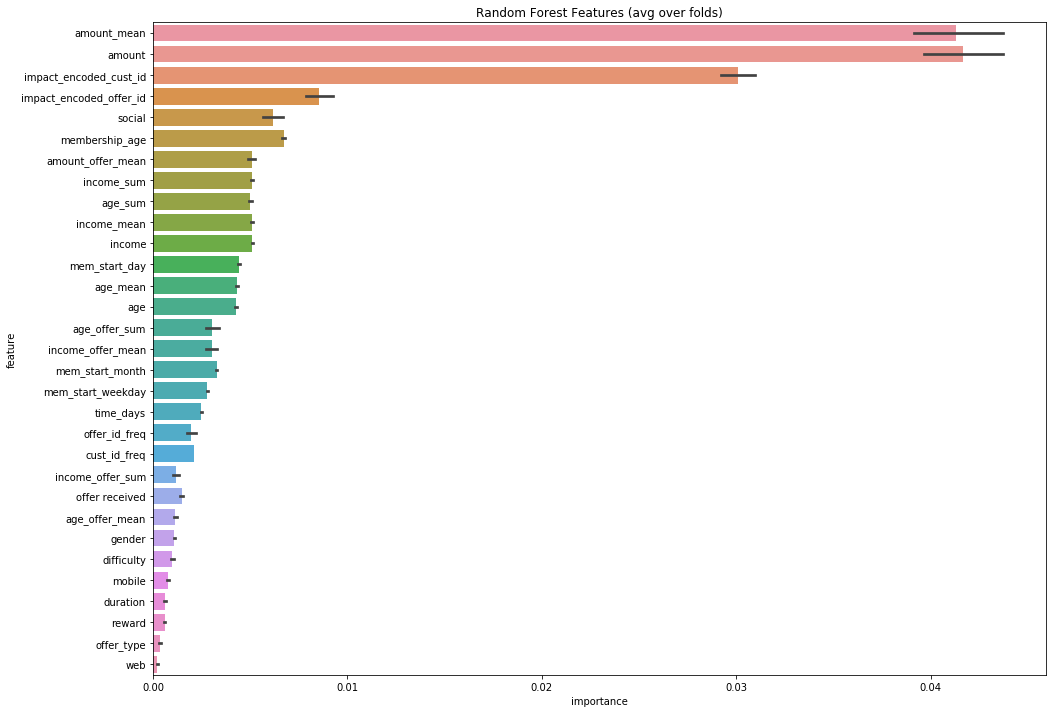

In [129]:
%%time
rf_params = {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
prediction_rf_cv,_ = train_model(X, X_test, y, params=rf_params, model_type='rf',plot_feature_importance=True)

# Plotting the Validation Metrics

In [130]:
#rf cv
report = classification_report(y_test, prediction_rf_cv.round(), output_dict=True )
df0=pd.DataFrame(list(report['0'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df0['class']=0
df1=pd.DataFrame(list(report['1'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df1['class']=1
df2 = pd.DataFrame(list(report['macro avg'].items()),columns = ['column1','column2']).transpose().rename(columns={0:'precision',1:'recall', 2:'f1-score', 3:'support'})
df2['class']='macro avg'
df_rf_cv = pd.concat([df0, df1, df2]).reset_index()
df_rf_cv = df_rf_cv[df_rf_cv['index']!='column1'].drop('index', axis=1)
df_rf_cv['accuracy']=report['accuracy']
df_rf_cv['model']='Random Forest tuned'

df = pd.concat([df_rf_cv, df])
df = df[df['class']=='macro avg'].sort_values(by='f1-score')

In [131]:
df_val = df.sort_values(by='f1-score').drop(['class','support'],axis=1)
df_val

,precision,recall,f1-score,accuracy,model
5,0.887469,0.880403,0.883494,0.888580,AdaBoost
5,0.893183,0.889779,0.891371,0.895647,Decision Tree
5,0.899408,0.890343,0.894207,0.899030,GBM
5,0.902394,0.89427,0.897789,0.902338,Light GBM
5,0.904348,0.897349,0.900438,0.904744,XGBoost
5,0.910467,0.907285,0.908785,0.912337,Random Forest
5,0.915854,0.907123,0.910897,0.914894,Random Forest tuned


In [132]:
df_ind = df[['model','precision','recall','f1-score','accuracy']].set_index('model').transpose()
df_ind

model,AdaBoost,Decision Tree,GBM,Light GBM,XGBoost,Random Forest,Random Forest tuned
precision,0.887469,0.893183,0.899408,0.902394,0.904348,0.910467,0.915854
recall,0.880403,0.889779,0.890343,0.89427,0.897349,0.907285,0.907123
f1-score,0.883494,0.891371,0.894207,0.897789,0.900438,0.908785,0.910897
accuracy,0.88858,0.895647,0.89903,0.902338,0.904744,0.912337,0.914894


In [133]:
#del df, df_ind

In [138]:
buttons = []
ind_list = []

fig = go.Figure()

for i, column in enumerate(df_ind.index):
    #fig.add_trace(go.Pie(labels=df_ind.keys(), values = df_ind.values[i]))
    fig.add_trace(go.Bar(x=df_ind.keys(), y = df_ind.values[i], name = column))
    fig.update_traces(textposition='inside')
    ind_list.append(column)
    
for i in df_ind.index:
    buttons.append(dict(method='update',
                        label=i, 
                        args = [{'visible': [i==r for r in ind_list]}]
                       )
                  ) 
button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df_ind.columns.isin(df_ind.columns),
                               'title': 'All'
                               }]
                )    
    
# Add dropdown menus to the figure
fig.update_layout(showlegend=True, updatemenus=[{"buttons": [button_all] + buttons, 
                                                  "direction": "down", 
                                                 #"active": 0, 
                                                  "showactive": True, 
                                                  "x": 0.5, "y": 1.15
                                                 # "x": 1, "y": 1.25
                                                 }]
                 ,width=900, height = 500)    
  
fig.show()  

In [139]:
import chart_studio
import chart_studio.plotly as py

username = 'dgbudale'
api_key = 'cT8i6sXKiIORlMZybVxX'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

py.iplot(fig, filename='chart1', auto_open=True)

In [136]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, prediction_rf_cv.round()).ravel()
print("True Negatives : ",tn)
print("False Positives (offer was fail but predicted success): ",fp)
print("False Negatives (offer was success but predicted fail): ",fn)
print("True Positives: ",tp)

True Negatives :  4676
False Positives (offer was fail but predicted success):  725
False Negatives (offer was success but predicted fail):  407
True Positives:  7493


In [137]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, prediction_rf_cv.round()).ravel()
print("True Negatives Rate: ",round(tn/(tn+fp),4))
print("False Positives Rate (offer was fail but predicted success): ",round(fp/(fp+tn),4))
print("False Negatives Rate(offer was success but predicted fail): ",round(fn/(fn+tp),4))
print("True Positives Rate: ",round(tp/(tp+fn),4))

True Negatives Rate:  0.8658
False Positives Rate (offer was fail but predicted success):  0.1342
False Negatives Rate(offer was success but predicted fail):  0.0515
True Positives Rate:  0.9485
